# Using Machine Learning Tools Assignment 1

## Overview

In this assignment, you will apply some popular machine learning techniques to the problem of predicting bike rental demand. A data set has been provided containing records of bike rentals in Seoul, collected during 2017-18.

The main aims of the prac are: 

- to practice using tools for loading and viewing data sets;
- to visualise data in several ways and check for common pitfalls;
- to plan a simple experiment and prepare the data accordingly;
- to run your experiment and to report and interpret your results clearly and concisely.

This assignment relates to the following ACS CBOK areas: abstraction, design, hardware and software, data and information, HCI and programming.

## General instructions

This assignment is divided into several tasks. Use the spaces provided in this notebook to answer the questions posed in each task. Note that some questions require writing a small amount of code, some require graphical results, and some require comments or analysis as text. It is your responsibility to make sure your responses are clearly labelled and your code has been fully executed (with the correct results displayed) before submission!

**Do not** manually edit the data set file we have provided! For marking purposes, it's important that your code runs correctly on the original data file.

None of the tasks in this assignment require writing more than a few lines of code! One goal of the assignment is explore [sklearn](https://scikit-learn.org/stable/index.html), [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html), [matplotlib](https://matplotlib.org/stable/index.html) and other libraries you will find useful throughout the course, so feel free to use the functions they provide. You are expected to search and carefully read the documentation for functions that you use, to ensure you are using them correctly.

Chapter 2 of the reference book is based on a similar workflow to this prac, so you may look there for some further background and ideas.

The following code imports some libraries we will need. You should not need to modify it.


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import pandas as pd
assert pd.__version__ >= "1.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Step 1: Load and pre-process the data set (20\%)

Download the data set from MyUni using the link provided on the assignment page. The original source for this data is the [UCI Data Repository](https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand#), but for consistency you should **use the local copy** we've provided. The webpage also contains a link to a useful paper describing the data set, which you should look at for further information.

The data is stored in a CSV (comma separated variable) file. This is a text format, so you can open the file in a text editor, or in a spreadsheet program, to have a look at it and check that it is what you expect.

Load the data set from the csv file into a DataFrame, and summarise it with appropriate pandas functions such as `info()` and `describe()`. Further information about the meaning of each feature is available in the paper linked above.

In [3]:
bike=pd.read_csv('SeoulBikeData.csv')
print(np.sum(bike.isna()),'\n')               # to check whether there is na in the data set
bike.info()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature (C)              0
Humidity (%)                 0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature (C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature (C)            8760 non-null   float64
 4   Humidity (%)               8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   floa

We want to predict future bike rental demand from this data. Hence our target feature is "Bike Rental Count". We will use regression techniques to do this, but this requires that our other features are numerical.

Answer the following questions in the cell below:

- How many samples are included in the data set?
- Are there any missing or invalid values in the data?
- Are any features not numerical? If so, which ones?

***
#### 1. 8760 samples are included in the data set.
#### 2. According to the result of 'bike.isna()' and 'bike.info()', there are no missing or invalid values.
#### 3. Yes, in the data set, 'Seasons', 'Holiday' and 'Functioning Day' are object. 'Date' is also object.
***

### 1.2 Functioning days

The "Functioning day" feature records whether the bike rental was open for business on that day. We are only interested in predicting demand on days when the business is open, so remove rows from the DataFrame where the business is closed. Hint: you can use the `DataFrame.loc()` function to do this. As a sanity check, ensure that the rows you are removing contain zero bike rentals! After doing this, delete the Functioning Day feature from the DataFrame (you can use `del` to do this).

In [4]:
a_bike = bike[bike['Functioning Day']!='No'].copy()             # creat a copy of rows which values in 'Functioning Day' are 'Yes' 
del a_bike['Functioning Day']                                   # delete the 'Functioning Day' column
a_bike.info()                                                   # number of rows reduce from 8760 to 8465

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8465 non-null   object 
 1   Rented Bike Count          8465 non-null   int64  
 2   Hour                       8465 non-null   int64  
 3   Temperature (C)            8465 non-null   float64
 4   Humidity (%)               8465 non-null   int64  
 5   Wind speed (m/s)           8465 non-null   float64
 6   Visibility (10m)           8465 non-null   int64  
 7   Dew point temperature (C)  8465 non-null   float64
 8   Solar Radiation (MJ/m2)    8465 non-null   float64
 9   Rainfall(mm)               8465 non-null   float64
 10  Snowfall (cm)              8465 non-null   float64
 11  Seasons                    8465 non-null   object 
 12  Holiday                    8465 non-null   object 
dtypes: float64(6), int64(4), object(3)
memory usage:

### 1.3 Holidays and seasons

The Holiday and Season features both contain potentially useful information, but they need to be converted to a numerical format. Write code to convert the Holiday feature to 0 or 1 from its current format. 

The Season feature is a little tricker. We could assign each season a number, but a better solution in this case is to add 4 new columns, each labelled by a season, and each storing 0 or 1 according to the season in each row. In other words, the "Winter" column contains 1 whenever the season is winter, and 0 elsewhere. Do this for each season. Afterwards, remember to delete the Season feature. 

Explain in a comment at the top of your code why this method (called "one hot encoding") is preferable to simply assigning each season a number.

In [5]:
# The reason why one-hot encoding is preferable is that it would be easier for comparing the correlation between the feature and  
# 'Rented Bike Count' later. 0-1 gives a solid answer about whether this season contributes to the rent count, however 1,2,3,4 is 
# meaning less and confusing.

b_bike = a_bike.copy()                                     # to make sure that this cell can run individually
b_bike['Holiday'] = b_bike['Holiday'].replace(['No Holiday','Holiday'],[0,1])     # replace ''No Holiday' and 'Holiday' by 0 and 1
one_hot = pd.get_dummies(b_bike['Seasons'])                # returns a DataFrame object that contains four season columns 
print('Result of pd.get_dummies() is:\n', one_hot,'\n')
b_bike = b_bike.drop('Seasons',axis=1)                     # drop the season column
b_bike = b_bike.join(one_hot)                              # join 'one_hot' to 'bike'
print(b_bike.info())

Result of pd.get_dummies() is:
       Autumn  Spring  Summer  Winter
0          0       0       0       1
1          0       0       0       1
2          0       0       0       1
3          0       0       0       1
4          0       0       0       1
...      ...     ...     ...     ...
8755       1       0       0       0
8756       1       0       0       0
8757       1       0       0       0
8758       1       0       0       0
8759       1       0       0       0

[8465 rows x 4 columns] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8465 non-null   object 
 1   Rented Bike Count          8465 non-null   int64  
 2   Hour                       8465 non-null   int64  
 3   Temperature (C)            8465 non-null   float64
 4   Humidity (%)               8465 non-null   int64 

### 1.4 Weekday or weekend?

Finally, let's look at the Date feature. Talking with the rental shop operator, you discover that the date is important because bike rentals depend strongly on whether it's a weekday or a weekend. We will therefore replace the Date feature with a Weekday feature that stores 0 or 1 depending on whether the date represents a weekend or weekday. 

To do this, write a small function that:
1. Converts a date string into 3 numbers representing the day, month and year. Hint: Python has a `split()` function for strings. 
2. Tests whether the date was a weekday (you can use `datetime.weekday()` to do this) and returns the result.

Apply the function to the Date column in your DataFrame (you can use `DataFrame.transform` to apply it).

In [6]:
c_bike = b_bike.copy()
import datetime
def date_is_weekday(datestring):
    date = datetime.datetime.strptime(datestring,'%d/%m/%Y')     # strptime() will convert the date string to date according to the format
    if 0<=date.weekday()<=4:
        flag=1
    else:
        flag=0
    return flag                                                  # return 0 for weekend, 1 for weekday
    
c_bike['Date'] = c_bike['Date'].transform(date_is_weekday)       # apply the function to the 'Date' column
c_bike[c_bike['Date']==1]                                        # weekday has 6024 rows

,Date,Rented Bike Count,Hour,Temperature (C),Humidity (%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Autumn,Spring,Summer,Winter
0,1,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,0,0,1
1,1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,0,0,1
2,1,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,0,0,1
3,1,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,0,0,1
4,1,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,0,1,0,0,0
8756,1,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,0,1,0,0,0
8757,1,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,0,1,0,0,0
8758,1,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,0,1,0,0,0


Do a final check of your data set. You should now have 15 numerical features. It's time to dive in!

## Step 2: Visualise the data (15\%)

### 2.1 Histograms

To get an overall view of the data distribution, plot frequency histograms of each attribute in the data set. Display the histograms in your notebook and comment on what you observe, particularly if you see any problems.


array([[<AxesSubplot:title={'center':'Date'}>,
        <AxesSubplot:title={'center':'Rented Bike Count'}>,
        <AxesSubplot:title={'center':'Hour'}>,
        <AxesSubplot:title={'center':'Temperature (C)'}>],
       [<AxesSubplot:title={'center':'Humidity (%)'}>,
        <AxesSubplot:title={'center':'Wind speed (m/s)'}>,
        <AxesSubplot:title={'center':'Visibility (10m)'}>,
        <AxesSubplot:title={'center':'Dew point temperature (C)'}>],
       [<AxesSubplot:title={'center':'Solar Radiation (MJ/m2)'}>,
        <AxesSubplot:title={'center':'Rainfall(mm)'}>,
        <AxesSubplot:title={'center':'Snowfall (cm)'}>,
        <AxesSubplot:title={'center':'Holiday'}>],
       [<AxesSubplot:title={'center':'Autumn'}>,
        <AxesSubplot:title={'center':'Spring'}>,
        <AxesSubplot:title={'center':'Summer'}>,
        <AxesSubplot:title={'center':'Winter'}>]], dtype=object)

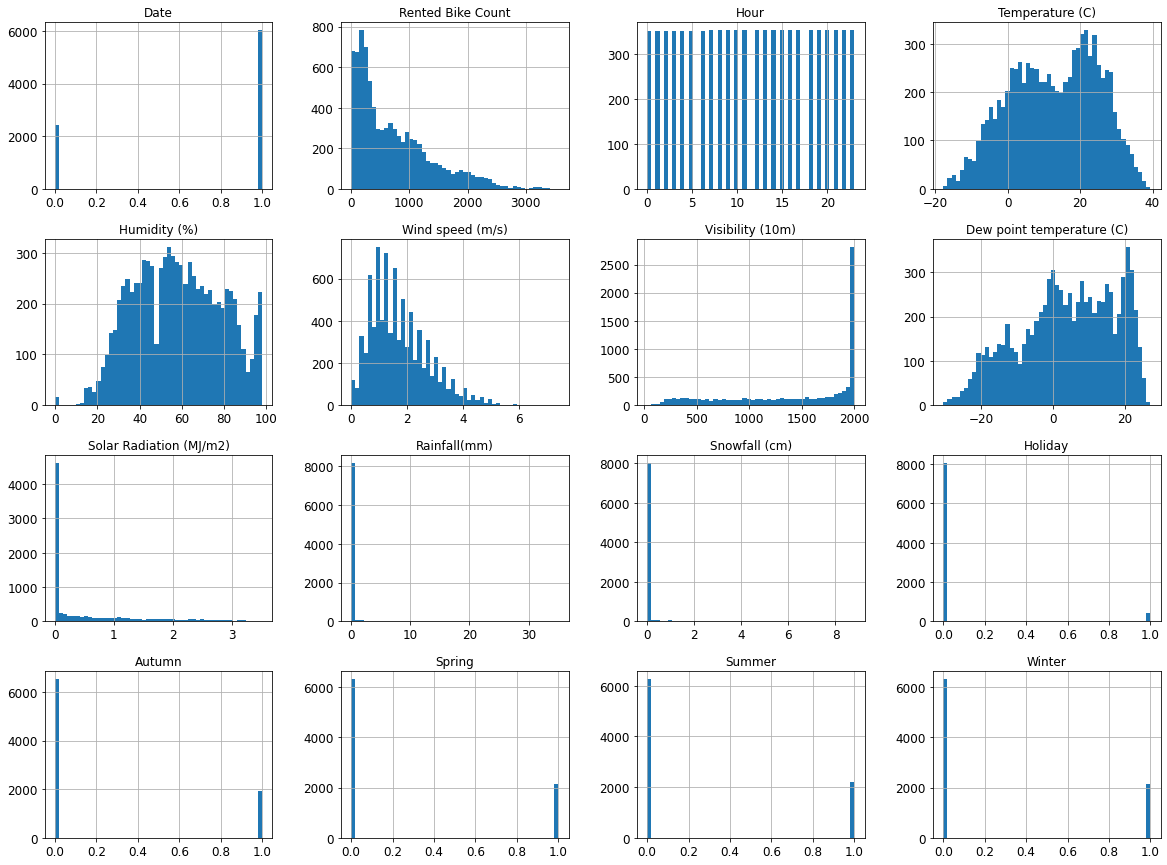

In [7]:
c_bike.hist(bins=50, figsize=(20,15))

***
#### 1. The attributes are of different types and scales. 
#### 2. After data processing, 'Date', 'Holiday' and 'Seasons' are Boolean values.
#### 3. The figures of 'Solar Radiation', 'Rainfall', 'Snowfall' are very similar. They may on a similar correlation level as well.
#### 4. The 'Visibility' value may be capped.
#### 5. The figures of 'Rented Bike Count' and 'Wind speed' are tail-heavy.
***

### 2.2 Correlation 

We are trying to predict the attribute "Bike Rental Count" from some combination of the other features. Calculate the correlation of each feature with bike rentals (Hint: pandas function `corr()`). Which 3 attributes are most correlated with bike rentals? For each of these 3 attributes, display a scatter plot of that attribute against bike rentals. Comment on what you observe.


Rented Bike Count            1.000000
Temperature (C)              0.562740
Hour                         0.425256
Dew point temperature (C)    0.400263
Summer                       0.282001
Solar Radiation (MJ/m2)      0.273862
Visibility (10m)             0.212323
Autumn                       0.165333
Wind speed (m/s)             0.125022
Date                         0.046360
Spring                       0.015580
Holiday                     -0.070070
Rainfall(mm)                -0.128626
Snowfall (cm)               -0.151611
Humidity (%)                -0.201973
Winter                      -0.458920
Name: Rented Bike Count, dtype: float64


<AxesSubplot:xlabel='Dew point temperature (C)', ylabel='Rented Bike Count'>

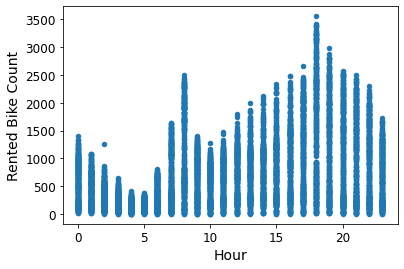

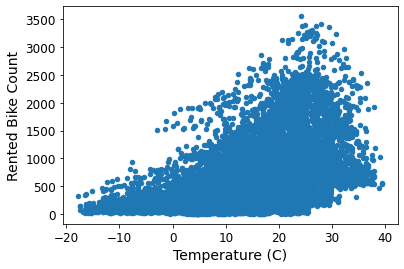

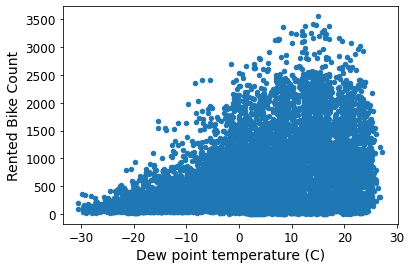

In [8]:
corr_matrix = c_bike.corr()
print(corr_matrix['Rented Bike Count'].sort_values(ascending=False))                   # sort the correlation matrix
c_bike.plot(kind='scatter', x='Hour', y='Rented Bike Count')                           # plot
c_bike.plot(kind='scatter', x='Temperature (C)', y='Rented Bike Count')
c_bike.plot(kind='scatter', x='Dew point temperature (C)', y='Rented Bike Count')

***
#### According to the correlation matrix:
#### 1. 'Hour', 'Temperature' and 'Dew point temperature' are the three attributes that most correlated with bike rentals.
#### 2. 'Winter' is also highly related, but it relate to the rented bike count negatively.
#### 3. There is a morning peak around 8 o'clock.
#### 4. 'Temperature' and 'Dew point temperature' are both temperatures, and they have similar figures.
***

## Step 3: Predicting bike rentals: baseline (15\%)

We will approach prediction as a regression problem: that is, we will pretend that "bike rentals" is a real number whose value we want to predict. If desired, we can round the value of our prediction to the nearest integer afterwards. 

We will use root mean square error (rmse) as our error function when evaluating our predictor:

$$rmse(h, y) = \sqrt { \frac{1}{m} \sum_{i=1}^{m} \left( h_i - y_i \right)^2}
$$

where $y_i$ is the actual value of the $i$th data point and $h_i$ is the value predicted by our model.

To perform prediction, we first need to split our data set into train and test sets. To start, do this by randomly selecting $20\%$ of the data as test data,  and use the remaining $80\%$ as training data. You can use the inbuilt function `train_test_split()` in sklearn to do this. The test data will not be used until the final evaluation of each model. 

Before we start training sophisticated models, it's useful to try a simple estimation method. This serves as a sanity check and provides a baseline performance against which to measure other models. Find the mean bike rental value in your training set, and use that as the predicted value for every data point (ignoring all attributes). Hint: You can use the `DummyRegressor` in sklearn to do this.

Draw a scatter plot (`plt.scatter`) with actual values on the x axis, and the residual at each point (i.e. predicted - actual) on the y axis. Is it what you expect?

What is the rmse for this predictor, when trained and tested on the *training* set? (Remember, the test set is not for use until later). Make sure your code outputs this clearly.


RMSE of dummy regression is: 645.9896442655572


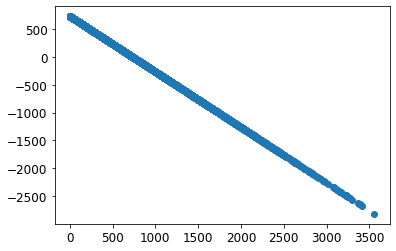

In [9]:
from sklearn import model_selection
from sklearn.dummy import DummyRegressor

# creat a DataFrame object with three attibutes and one label column (for experiment)
bike_3attr_1lab = pd.DataFrame([c_bike['Hour'],c_bike['Temperature (C)'],c_bike['Winter'],c_bike['Rented Bike Count']]).T

# I chose to use full data set instead of subset
train_set,test_set = model_selection.train_test_split(c_bike,test_size=0.2,random_state=0) 
X_train = train_set.drop('Rented Bike Count',axis=1)                           # define training attributes and training label
y_train = train_set['Rented Bike Count']


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()                                                             
X_train = scaler.fit_transform(X_train)                                        # use min-max scaler to scale the training attributes


dummy = DummyRegressor(strategy="mean")                                        # use dummy regressor to predict the result
dummy.fit(X_train,y_train)
y_pred_dum = dummy.predict(X_train)
plt.scatter(y_train,y_pred_dum-y_train)


from sklearn.metrics import mean_squared_error                                 # calculate mse and rmse
mse_dum = mean_squared_error(y_train,y_pred_dum)
rmse_dum = np.sqrt(mse_dum)
print('RMSE of dummy regression is:',rmse_dum)

## Step 4: Predicting bike rentals (20\%)

Fit a *linear regression* model to your training data. The `LinearRegression` model in sklearn will enable this. To get an idea of how successful this model is, apply it to your *training* data, plot the residuals as before, and calculate the rmse. 


RMSE of linear regression is: 434.2543868121378


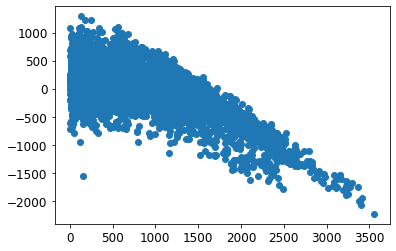

In [10]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_train)
plt.scatter(y_train,y_pred_lr-y_train)

mse_lr = mean_squared_error(y_train,y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
print('RMSE of linear regression is:',rmse_lr)

Fit a *k nearest neighbour* regression model to your training data, for varying values of k. This model is also available in sklearn, as `KNeighborsRegressor`, so you can apply it as you did the linear regressor. Again, plot the residuals and display the rmse.

RMSE of KNN (k=2) is: 150.56650934868722
RMSE of KNN (k=3) is: 179.4315648207594
RMSE of KNN (k=4) is: 198.95197133080057


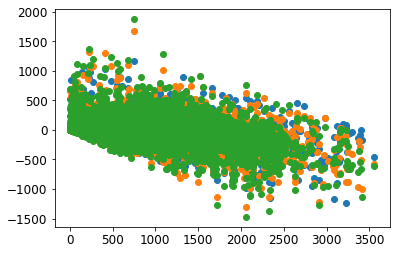

In [11]:
from sklearn.neighbors import KNeighborsRegressor

knn_2 = KNeighborsRegressor(n_neighbors=2)
knn_2.fit(X_train,y_train)
y_pred_knn_2 = knn_2.predict(X_train)
plt.scatter(y_train,y_pred_knn_2-y_train)
mse_knn_2 = mean_squared_error(y_train,y_pred_knn_2)
rmse_knn_2 = np.sqrt(mse_knn_2)
print('RMSE of KNN (k=2) is:',rmse_knn_2)

knn_3 = KNeighborsRegressor(n_neighbors=3)
knn_3.fit(X_train,y_train)
y_pred_knn_3 = knn_3.predict(X_train)
plt.scatter(y_train,y_pred_knn_3-y_train)
mse_knn_3 = mean_squared_error(y_train,y_pred_knn_3)
rmse_knn_3 = np.sqrt(mse_knn_3)
print('RMSE of KNN (k=3) is:',rmse_knn_3)

knn_4 = KNeighborsRegressor(n_neighbors=4)
knn_4.fit(X_train,y_train)
y_pred_knn_4 = knn_4.predict(X_train)
plt.scatter(y_train,y_pred_knn_4-y_train)
mse_knn_4 = mean_squared_error(y_train,y_pred_knn_4)
rmse_knn_4 = np.sqrt(mse_knn_4)
print('RMSE of KNN (k=4) is:',rmse_knn_4)

A slightly more powerful model is a *decision tree*. We will return to this model later in the course, but for now, apply it to the training data as you applied linear regression, using the `DecisionTreeRegressor` in sklearn. Again, plot the residuals and display the rmse.

RMSE of decision tree regression is: 0.0


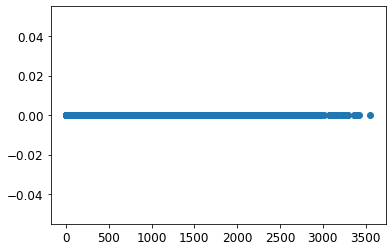

In [12]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train)
y_pred_dtr = dtr.predict(X_train)
plt.scatter(y_train,y_pred_dtr-y_train)

mse_dtr = mean_squared_error(y_train,y_pred_dtr)
rmse_dtr = np.sqrt(mse_dtr)
print('RMSE of decision tree regression is:',rmse_dtr)

Comment on the accuracy of each method and the settings you tried.  How do the errors compare and why do you think this is the case?

***
#### After trying 3(DataFrames)×3(models)×2(scaling or not) = 18 settings, the results are as follows:


|original|bike (15attr)|2+Dew point|2+Winter||||||||||min-max|bike (15attr)|2+Dew point|2+Winter|
|---|---|---|---||||||||||---|---|---|---|
|linear|434.254|462.584|473.55||||||||||linear|434.254|462.584|473.55|
|knn (k=2)|248.427|183.351|263.542||||||||||knn (k=2)|150.567|187.507|265.25|
|tree|0|18.029|194.289||||||||||tree|0|18.029|194.289|

Decision tree has an overall better performance on RMSE results than others, but the differences between original and min-max scaling is subtle. I assume that min-max scaling does not contribute much to the results in this case, or that some algorithms are not affected by scaling. Regarding data set selection, the full data set is better than the combination of three most correlated attributes, so I think that maybe each attribute contributes more or less to the model accuracy.
***



## Step 5: Cross validation (20\%)

At this point, we are still evaluating our models on the *training data* only. Achieving a low error on the the training data does not necessarily mean the model will perform well on the test data. For example, a powerful model with many parameters may overfit to the training data.

Cross validation lets us test our models by repeatedly splitting the training data into separate training and validation sets, and testing performance on "unseen" data in the validation set. Perform *10 fold cross validation* for each model. This splits the training set into 10 equal size subsets, and uses each in turn as the validation set while training a model with the other 9. You should therefore have 10 error values for each cross validation run.

Display the mean and standard deviation of the error values obtained for each model.

In [13]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr,X_train,y_train,scoring='neg_root_mean_squared_error',cv=10)
print('Linear regression mean:',-scores.mean())
print('Linear regression std:',scores.std(),'\n')

scores = cross_val_score(knn_2,X_train,y_train,scoring='neg_root_mean_squared_error',cv=10)
print('K neighbors mean:',-scores.mean())
print('K neighbors std:',scores.std(),'\n')

scores = cross_val_score(dtr,X_train,y_train,scoring='neg_root_mean_squared_error',cv=10)
print('Decision tree mean:',-scores.mean())
print('Decision tree std:',scores.std())

Linear regression mean: 435.3586585623772
Linear regression std: 14.486995496735815 

K neighbors mean: 276.1179785453173
K neighbors std: 12.64927386763036 

Decision tree mean: 251.79686489729255
Decision tree std: 17.947887676888392


Comment on what you find. On this basis, what do you think is the most suitable model that you've tried? 

***
#### Based on the same settings, the results are as follows:
|original|bike (15attr)|2+Dew point|2+Winter||||||||||min-max|bike (15attr)|2+Dew point|2+Winter|
|---|---|---|---||||||||||---|---|---|---|
|linear|435±14|462±13|473±15||||||||||linear|435±14|462±13|473±15|
|knn (k=2)|436±15|314±12|425±11||||||||||knn (k=2)|276±12|323±10|428±14|
|tree|247±20|378±15|473±12||||||||||tree|247±20|380±17|470±17|

Decision tree has a better performance than other models, it would be more suitable for this task.
***

## Step 6: Grid parameter search (10%)

Both the kNN and Decision Tree regressors have several hyperparameters that can be set to suit the problem. For either the kNN or Decision tree regressor (whichever you found more suitable), use grid search to systematically compare the error obtained with different hyperparameter settings. Use the sklearn function `GridSearchCV` to do this. 

For the kNN regressor, vary settings for the `n_neighbors` and `weights` hyperparameters.
For the decision tree regressor, vary settings for the `max_depth` and `max_features` hyperparameters.

Print out the best hyperparameter settings for your chosen method. Finally, apply your chosen method, with those parameter settings, to the *test set*. 

Best parameters for decision tree are: {'max_depth': 10, 'max_features': 15}
RMSE for the test set is: 241.64399170450665


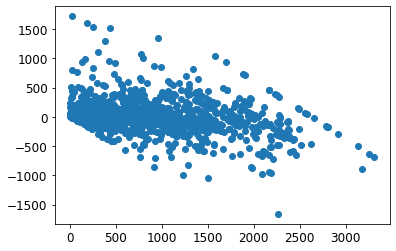

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
# my original search scale was 'max_depth':[1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80],'max_features':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# to fast the process, I'd narrow the scale (according to the result) to:
dtr_para_grid = {'max_depth':[8,9,10,20],'max_features':[10,11,12,13,14,15]}
dtr = DecisionTreeRegressor()    
grid_search = GridSearchCV(dtr,dtr_para_grid,cv=10,scoring='neg_root_mean_squared_error',return_train_score=True)
grid_search.fit(X_train,y_train)
print('Best parameters for decision tree are:',grid_search.best_params_)

fin_dtr_para = grid_search.best_estimator_                                     # apply the best best_estimator_
X_test = test_set.drop('Rented Bike Count',axis=1)
y_test = test_set['Rented Bike Count']
scaler = MinMaxScaler()                                       
X_test = scaler.fit_transform(X_test)                                          # use min-max scaler to scale the test set

fin_pred = fin_dtr_para.predict(X_test)                                        # predict
fin_mse = mean_squared_error(y_test,fin_pred)
fin_rmse = np.sqrt(fin_mse)
print('RMSE for the test set is:',fin_rmse)                                    # output the final rmse
plt.scatter(y_test,fin_pred-y_test)

Comment on your final result. Is it as expected? Finally, summarise what you've learnt doing this exercise and what your results have shown.

**Yes, the final RMSE stabilises at around 240, which is pretty close to the result of cross validation. 18 settings were tested in this task. The results show that the decision tree has an overall better performance than the other models, and using the full data set is better than using a data set with only three most correlated attributes. In terms of RMSE, the result of the test set and cross-validation are not very different, so I think cross-validation can be a useful indicator for selecting models. Regarding data scaling, it is helpful for some models, so instead of deleting the code, I applied the same transformation to the test set.  I've learned so much doing this exercise. To complete the assignment, I needed to figure out what is the common process of a machine learning task, how to do the analysis step by step, and finally put the theory into practice. These skills will be really helpful for the next stage of my study.**

***
#### CHEN Chen a1819099, 29-Mar-2021